In [1]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline


Quantum algorithms on the Xanadu quantum cloud
==============================================

In this tutorial, we program photonic devices available on the Xanadu cloud platform to implement
proof-of-principle algorithms for Gaussian boson sampling, molecular vibronic spectra, and graph
similarity. You will learn how to use Strawberry Fields 🍓 to
program the chips and process the output samples for each task. We follow closely the results
presented in the paper "Quantum circuits with many photons on a programmable nanophotonic chip"
[[#arrazola2021]_].

More details on how to submit jobs to the Xanadu cloud can be found in
:doc:`this tutorial </demos/tutorial_X8>`. Additional information on the algorithms themselves
can be found in the tutorials for :doc:`vibronic spectra
</apps/run_tutorial_vibronic>` and :doc:`graph similarity </apps/run_tutorial_similarity>`.

Finally, an authentication token is required to access hardware ️🔑. If you do not have an
authentication token, please sign up for hardware access via
`Xanadu Cloud <https://platform.xanadu.ai/auth/realms/platform/protocol/openid-connect/registrations?client_id=public&redirect_uri=https%3A%2F%2Fcloud.xanadu.ai%2Flogin&response_type=code>`__.


Remote programming of photonic chips
------------------------------------
Strawberry Fields is a software platform for photonic quantum computing --- it provides access
to tools for designing and simulating photonic circuits, and also serves as the application
programming interface for photonic hardware on the Xanadu cloud. In this tutorial, we program
X8 devices, which consist of eight modes separated into four spatial modes, each carrying
two separate frequencies. We call modes 0 to 3 the signal modes and modes 4 to 7 the idler modes.

The circuit architecture consists of the following components:

* Firstly, two mode squeezing operations act on each pair of
  signal/idler modes. Squeezing can be turned on or off for a fixed squeezing level.

* The second component of the circuit is a universal four-mode interferometer
  acting equally on signal and idler modes.

* Finally, output modes are probed using transition-edge sensors capable
  of counting the number of photons.

The figure below shows a micrograph of the chip, a photograph of the
complete system fit to a standard server rack, and a schematic of the control system.

![](/tutorials/images/overview.svg)

    :align: center
    :width: 70%
    :target: javascript:void(0);


Gaussian boson sampling
-----------------------

:doc:`Gaussian boson sampling </demos/run_gaussian_boson_sampling>` is a platform for photonic
quantum computing where a Gaussian state is measured in the photon-number basis. The
combinations of squeezing and interferometer operations implemented in Xanadu's hardware
generate a Gaussian output state, so these devices can be used to implement Gaussian boson
sampling. When the interferometers are programmed according to random unitaries, arguments from
computational complexity theory can be invoked to argue that the output distribution cannot be
sampled from efficiently using classical computers.

`Haar-random unitaries
<https://pennylane.ai/qml/demos/tutorial_haar_measure.html>`__ can be generated
using the :func:`~strawberryfields.utils.random_interferometer` function.


In [16]:
from strawberryfields.utils import random_interferometer
U_GBS = random_interferometer(4)

We define a program on eight modes where two-mode squeezing gates are applied to each pair of
signal-idler modes. To maximize the number of photons generated, we turn all squeezers on and
program the interferometer according to the random unitary generated above.



In [17]:
import strawberryfields as sf
from strawberryfields import ops

nr_modes = 8
gbs_prog = sf.Program(nr_modes)
with gbs_prog.context as q:
    # Two-mode squeezing. Allowed values are r=1.0 (on) or r=0.0 (off)
    ops.S2gate(1.0) | (q[0], q[4])
    ops.S2gate(1.0) | (q[1], q[5])
    ops.S2gate(1.0) | (q[2], q[6])
    ops.S2gate(1.0) | (q[3], q[7])

    # Equal interferometers on signal and idler modes
    ops.Interferometer(U_GBS) | (q[0], q[1], q[2], q[3])
    ops.Interferometer(U_GBS) | (q[4], q[5], q[6], q[7])

    # Measure output state in the Fock basis
    ops.MeasureFock() | q

This program can then be executed across any compatible device. We run the remote
engine to request 400,000 samples (four hundred thousand samples! 🤯) from Xanadu's X8 chip.



In [18]:
from strawberryfields import RemoteEngine

eng = sf.RemoteEngine("X8")
gbs_results = eng.run(gbs_prog, shots=400000)
gbs_samples = gbs_results.samples

2025-06-08 22:22:19,331 - INFO - Compiling program for device X8_01 using compiler Xunitary.


HTTPError: The target specified for this job (X8_01) is not online.

To visualize the results, we create a histogram depicting the probabilities of observing
all possible patterns with four photons. These can be arranged into orbits that
describe how the photons are distributed across modes. For example the orbit $[1, 1, 1,
1]$ is the set of all patterns where a single photon is detected in four different modes, e.g.,
$[0, 1, 1, 0, 0, 1, 0, 1]$. Similarly the orbit $[2, 2]$ is the set of all patterns
where two photons are detected in one mode and two photons are detected in another mode, e.g.,
$[0, 0, 2, 0, 2, 0, 0, 0]$.



To visualize the results, we create a histogram depicting the probabilities of observing
all possible patterns with four photons. These can be arranged into orbits that
describe how the photons are distributed across modes. For example the orbit $[1, 1, 1,
1]$ is the set of all patterns where a single photon is detected in four different modes, e.g.,
$[0, 1, 1, 0, 0, 1, 0, 1]$. Similarly the orbit $[2, 2]$ is the set of all patterns
where two photons are detected in one mode and two photons are detected in another mode, e.g.,
$[0, 0, 2, 0, 2, 0, 0, 0]$.



In [5]:
from sympy.utilities.iterables import multiset_permutations
from strawberryfields.apps.similarity import orbits
import numpy as np

nr_photons = 4

# generate all possible patterns and count the number in each orbit
patterns = []
counts = []
counter = 0
for orb in orbits(nr_photons):
    orb = orb + [0] * (nr_modes - len(orb))
    for p in multiset_permutations(orb):
        patterns.append(p)
        counter += 1
    counts.append(counter)

patterns = np.array(patterns)
nr_patterns = len(patterns)

print(list(orbits(nr_photons)))
print(counts)

[[1, 1, 1, 1], [2, 1, 1], [3, 1], [2, 2], [4]]
[70, 238, 294, 322, 330]


.. rst-class:: sphx-glr-script-out

 Out:

 .. code-block:: none

      [[1, 1, 1, 1], [2, 1, 1], [3, 1], [2, 2], [4]]
      [70, 238, 294, 322, 330]



To create the histogram, we use a python dictionary that assigns a unique number to each pattern,
making it easy to record the number of times each pattern is observed.



In [6]:
sample_dict = {}
for i in range(nr_patterns):
    sample_dict[str(patterns[i])] = i

We iterate over all samples with four photons, keeping track of the number of times each
pattern appears. The resulting array is normalized so its entries sum to unity.
This provides an empirical estimate of the conditional probability of observing each pattern
across samples with four photons.



In [7]:
from strawberryfields.apps.sample import postselect

# post-select samples on outputs with four photons
gbs_samples = postselect(gbs_samples, nr_photons, nr_photons)

probs_samples = np.zeros(nr_patterns)

for s in gbs_samples:
    index = sample_dict[str(s)]
    probs_samples[index] += 1

norm = np.sum(probs_samples)
probs_samples = np.array([p / norm for p in probs_samples])

We plot the reconstructed probability distribution. We use a different
colour for each of the five orbit of four photons: $[1,1,1,1]$, $[2,1,1]$,
$[3,1]$, $[2,2]$, $[4]$. The resulting histogram depicts that some patterns
occur with higher probability than others.



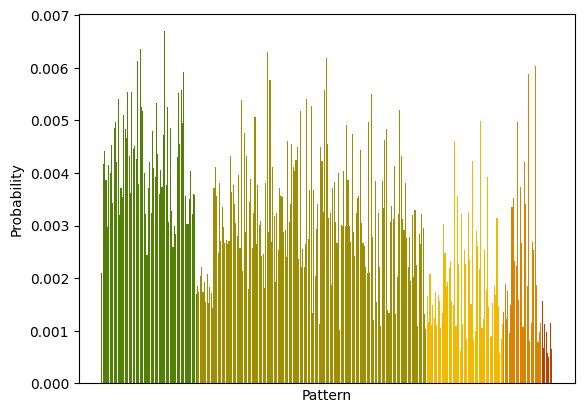

In [8]:
import matplotlib.pyplot as plt

plt.figure()
x = np.arange(nr_patterns)
plt.bar(x[:counts[0]], probs_samples[:counts[0]], color="#508104")
plt.bar(x[counts[0]:counts[1]], probs_samples[counts[0]:counts[1]], color="#9e8e01")
plt.bar(x[counts[1]:counts[2]], probs_samples[counts[1]:counts[2]], color="#f3b800")
plt.bar(x[counts[2]:counts[3]], probs_samples[counts[2]:counts[3]], color="#db8200")
plt.bar(x[counts[3]:counts[4]], probs_samples[counts[3]:counts[4]], color="#b64201")
plt.xlabel("Pattern")
plt.xticks([], [])
plt.ylabel("Probability")
plt.show()

![](/tutorials/images/GBS_histogram.svg)

    :align: center
    :width: 66%


Vibronic spectra
----------------
Molecules can absorb light when they undergo a transition between different vibrational and
electronic (vibronic) states. The vibronic spectrum of a
molecule describes the wavelengths of light that are more strongly absorbed in this process. In
the photonic algorithm for vibronic spectra, optical modes represent the vibrational
normal modes of the molecule. The device is programmed to replicate the transformation
experienced by the vibrational modes during a vibronic transition.

In this proof-of-principle demonstration, we program the device according to the interferometer
transformations that result from the mode-mixing of ethylene upon a vibronic transition. This
interferometer is described by the following unitary:



In [9]:
U_vibronic = np.array([
    [-0.5349105592386603, 0.8382670887228271, 0.10356058421030308, -0.021311662937477004],
    [-0.6795134137271818, -0.4999083619063322, 0.5369830827402383, 0.001522863010877817],
    [-0.4295084785810517, -0.17320833713971984, -0.7062800928050401, 0.5354341876268153],
    [0.2601051345260338, 0.13190447151471643, 0.4495473331653913, 0.8443066531962792]
])

We define a new program to execute the vibronic spectrum algorithm. We only include
squeezing on the first pair of modes.



In [10]:
eng = sf.RemoteEngine("X8")
vibronic_prog = sf.Program(nr_modes)

with vibronic_prog.context as q:
    ops.S2gate(1.0) | (q[0], q[4])

    ops.Interferometer(U_vibronic) | (q[0], q[1], q[2], q[3])
    ops.Interferometer(U_vibronic) | (q[4], q[5], q[6], q[7])

    ops.MeasureFock() | q

vibronic_results = eng.run(vibronic_prog, shots=400000)
vibronic_samples = vibronic_results.samples

2025-06-02 13:30:49,474 - INFO - Compiling program for device X8_01 using compiler Xunitary.
2025-06-02 13:31:07,598 - INFO - The remote job 9a9b21ad-3a47-4633-abce-be1ebb2cebd3 has been completed.


The Strawberry Fields applications module contains functionality for reconstructing vibronic
spectra. Each photon pattern is assigned an energy that can be used to
reconstruct a histogram. The peaks of this histogram represent the absorption lines
of the molecule's vibronic spectrum. We employ a convention where zero energy is assigned to a
transition between vibrational ground states of the initial and final electronic states,
which correspond to vacuum outputs.



In [14]:
from strawberryfields.apps import vibronic, plot
import plotly

vibronic_samples = [list(s) for s in vibronic_samples]

# frequencies of the initial and final normal modes
w = [2979, 1580, 1286, 977]
wp = [2828, 1398, 1227, 855]
energies = vibronic.energies(vibronic_samples, w, wp)
# MAS: plotly version matters:  pip install plotly==4.14.3
plot.spectrum(energies, xmin=-6000, xmax=6000)          

ValueError: Invalid property specified for object of type plotly.graph_objs.layout.XAxis: 'titlefont'

Did you mean "tickfont"?

    Valid properties:
        anchor
            If set to an opposite-letter axis id (e.g. `x2`, `y`),
            this axis is bound to the corresponding opposite-letter
            axis. If set to "free", this axis' position is
            determined by `position`.
        automargin
            Determines whether long tick labels automatically grow
            the figure margins.
        autorange
            Determines whether or not the range of this axis is
            computed in relation to the input data. See `rangemode`
            for more info. If `range` is provided and it has a
            value for both the lower and upper bound, `autorange`
            is set to False. Using "min" applies autorange only to
            set the minimum. Using "max" applies autorange only to
            set the maximum. Using *min reversed* applies autorange
            only to set the minimum on a reversed axis. Using *max
            reversed* applies autorange only to set the maximum on
            a reversed axis. Using "reversed" applies autorange on
            both ends and reverses the axis direction.
        autorangeoptions
            :class:`plotly.graph_objects.layout.xaxis.Autorangeopti
            ons` instance or dict with compatible properties
        autotickangles
            When `tickangle` is set to "auto", it will be set to
            the first angle in this array that is large enough to
            prevent label overlap.
        autotypenumbers
            Using "strict" a numeric string in trace data is not
            converted to a number. Using *convert types* a numeric
            string in trace data may be treated as a number during
            automatic axis `type` detection. Defaults to
            layout.autotypenumbers.
        calendar
            Sets the calendar system to use for `range` and `tick0`
            if this is a date axis. This does not set the calendar
            for interpreting data on this axis, that's specified in
            the trace or via the global `layout.calendar`
        categoryarray
            Sets the order in which categories on this axis appear.
            Only has an effect if `categoryorder` is set to
            "array". Used with `categoryorder`.
        categoryarraysrc
            Sets the source reference on Chart Studio Cloud for
            `categoryarray`.
        categoryorder
            Specifies the ordering logic for the case of
            categorical variables. By default, plotly uses "trace",
            which specifies the order that is present in the data
            supplied. Set `categoryorder` to *category ascending*
            or *category descending* if order should be determined
            by the alphanumerical order of the category names. Set
            `categoryorder` to "array" to derive the ordering from
            the attribute `categoryarray`. If a category is not
            found in the `categoryarray` array, the sorting
            behavior for that attribute will be identical to the
            "trace" mode. The unspecified categories will follow
            the categories in `categoryarray`. Set `categoryorder`
            to *total ascending* or *total descending* if order
            should be determined by the numerical order of the
            values. Similarly, the order can be determined by the
            min, max, sum, mean, geometric mean or median of all
            the values.
        color
            Sets default for all colors associated with this axis
            all at once: line, font, tick, and grid colors. Grid
            color is lightened by blending this with the plot
            background Individual pieces can override this.
        constrain
            If this axis needs to be compressed (either due to its
            own `scaleanchor` and `scaleratio` or those of the
            other axis), determines how that happens: by increasing
            the "range", or by decreasing the "domain". Default is
            "domain" for axes containing image traces, "range"
            otherwise.
        constraintoward
            If this axis needs to be compressed (either due to its
            own `scaleanchor` and `scaleratio` or those of the
            other axis), determines which direction we push the
            originally specified plot area. Options are "left",
            "center" (default), and "right" for x axes, and "top",
            "middle" (default), and "bottom" for y axes.
        dividercolor
            Sets the color of the dividers Only has an effect on
            "multicategory" axes.
        dividerwidth
            Sets the width (in px) of the dividers Only has an
            effect on "multicategory" axes.
        domain
            Sets the domain of this axis (in plot fraction).
        dtick
            Sets the step in-between ticks on this axis. Use with
            `tick0`. Must be a positive number, or special strings
            available to "log" and "date" axes. If the axis `type`
            is "log", then ticks are set every 10^(n*dtick) where n
            is the tick number. For example, to set a tick mark at
            1, 10, 100, 1000, ... set dtick to 1. To set tick marks
            at 1, 100, 10000, ... set dtick to 2. To set tick marks
            at 1, 5, 25, 125, 625, 3125, ... set dtick to
            log_10(5), or 0.69897000433. "log" has several special
            values; "L<f>", where `f` is a positive number, gives
            ticks linearly spaced in value (but not position). For
            example `tick0` = 0.1, `dtick` = "L0.5" will put ticks
            at 0.1, 0.6, 1.1, 1.6 etc. To show powers of 10 plus
            small digits between, use "D1" (all digits) or "D2"
            (only 2 and 5). `tick0` is ignored for "D1" and "D2".
            If the axis `type` is "date", then you must convert the
            time to milliseconds. For example, to set the interval
            between ticks to one day, set `dtick` to 86400000.0.
            "date" also has special values "M<n>" gives ticks
            spaced by a number of months. `n` must be a positive
            integer. To set ticks on the 15th of every third month,
            set `tick0` to "2000-01-15" and `dtick` to "M3". To set
            ticks every 4 years, set `dtick` to "M48"
        exponentformat
            Determines a formatting rule for the tick exponents.
            For example, consider the number 1,000,000,000. If
            "none", it appears as 1,000,000,000. If "e", 1e+9. If
            "E", 1E+9. If "power", 1x10^9 (with 9 in a super
            script). If "SI", 1G. If "B", 1B.
        fixedrange
            Determines whether or not this axis is zoom-able. If
            true, then zoom is disabled.
        gridcolor
            Sets the color of the grid lines.
        griddash
            Sets the dash style of lines. Set to a dash type string
            ("solid", "dot", "dash", "longdash", "dashdot", or
            "longdashdot") or a dash length list in px (eg
            "5px,10px,2px,2px").
        gridwidth
            Sets the width (in px) of the grid lines.
        hoverformat
            Sets the hover text formatting rule using d3 formatting
            mini-languages which are very similar to those in
            Python. For numbers, see:
            https://github.com/d3/d3-format/tree/v1.4.5#d3-format.
            And for dates see: https://github.com/d3/d3-time-
            format/tree/v2.2.3#locale_format. We add two items to
            d3's date formatter: "%h" for half of the year as a
            decimal number as well as "%{n}f" for fractional
            seconds with n digits. For example, *2016-10-13
            09:15:23.456* with tickformat "%H~%M~%S.%2f" would
            display "09~15~23.46"
        insiderange
            Could be used to set the desired inside range of this
            axis (excluding the labels) when `ticklabelposition` of
            the anchored axis has "inside". Not implemented for
            axes with `type` "log". This would be ignored when
            `range` is provided.
        labelalias
            Replacement text for specific tick or hover labels. For
            example using {US: 'USA', CA: 'Canada'} changes US to
            USA and CA to Canada. The labels we would have shown
            must match the keys exactly, after adding any
            tickprefix or ticksuffix. For negative numbers the
            minus sign symbol used (U+2212) is wider than the
            regular ascii dash. That means you need to use −1
            instead of -1. labelalias can be used with any axis
            type, and both keys (if needed) and values (if desired)
            can include html-like tags or MathJax.
        layer
            Sets the layer on which this axis is displayed. If
            *above traces*, this axis is displayed above all the
            subplot's traces If *below traces*, this axis is
            displayed below all the subplot's traces, but above the
            grid lines. Useful when used together with scatter-like
            traces with `cliponaxis` set to False to show markers
            and/or text nodes above this axis.
        linecolor
            Sets the axis line color.
        linewidth
            Sets the width (in px) of the axis line.
        matches
            If set to another axis id (e.g. `x2`, `y`), the range
            of this axis will match the range of the corresponding
            axis in data-coordinates space. Moreover, matching axes
            share auto-range values, category lists and histogram
            auto-bins. Note that setting axes simultaneously in
            both a `scaleanchor` and a `matches` constraint is
            currently forbidden. Moreover, note that matching axes
            must have the same `type`.
        maxallowed
            Determines the maximum range of this axis.
        minallowed
            Determines the minimum range of this axis.
        minexponent
            Hide SI prefix for 10^n if |n| is below this number.
            This only has an effect when `tickformat` is "SI" or
            "B".
        minor
            :class:`plotly.graph_objects.layout.xaxis.Minor`
            instance or dict with compatible properties
        mirror
            Determines if the axis lines or/and ticks are mirrored
            to the opposite side of the plotting area. If True, the
            axis lines are mirrored. If "ticks", the axis lines and
            ticks are mirrored. If False, mirroring is disable. If
            "all", axis lines are mirrored on all shared-axes
            subplots. If "allticks", axis lines and ticks are
            mirrored on all shared-axes subplots.
        nticks
            Specifies the maximum number of ticks for the
            particular axis. The actual number of ticks will be
            chosen automatically to be less than or equal to
            `nticks`. Has an effect only if `tickmode` is set to
            "auto".
        overlaying
            If set a same-letter axis id, this axis is overlaid on
            top of the corresponding same-letter axis, with traces
            and axes visible for both axes. If False, this axis
            does not overlay any same-letter axes. In this case,
            for axes with overlapping domains only the highest-
            numbered axis will be visible.
        position
            Sets the position of this axis in the plotting space
            (in normalized coordinates). Only has an effect if
            `anchor` is set to "free".
        range
            Sets the range of this axis. If the axis `type` is
            "log", then you must take the log of your desired range
            (e.g. to set the range from 1 to 100, set the range
            from 0 to 2). If the axis `type` is "date", it should
            be date strings, like date data, though Date objects
            and unix milliseconds will be accepted and converted to
            strings. If the axis `type` is "category", it should be
            numbers, using the scale where each category is
            assigned a serial number from zero in the order it
            appears. Leaving either or both elements `null` impacts
            the default `autorange`.
        rangebreaks
            A tuple of
            :class:`plotly.graph_objects.layout.xaxis.Rangebreak`
            instances or dicts with compatible properties
        rangebreakdefaults
            When used in a template (as
            layout.template.layout.xaxis.rangebreakdefaults), sets
            the default property values to use for elements of
            layout.xaxis.rangebreaks
        rangemode
            If "normal", the range is computed in relation to the
            extrema of the input data. If "tozero", the range
            extends to 0, regardless of the input data If
            "nonnegative", the range is non-negative, regardless of
            the input data. Applies only to linear axes.
        rangeselector
            :class:`plotly.graph_objects.layout.xaxis.Rangeselector
            ` instance or dict with compatible properties
        rangeslider
            :class:`plotly.graph_objects.layout.xaxis.Rangeslider`
            instance or dict with compatible properties
        scaleanchor
            If set to another axis id (e.g. `x2`, `y`), the range
            of this axis changes together with the range of the
            corresponding axis such that the scale of pixels per
            unit is in a constant ratio. Both axes are still
            zoomable, but when you zoom one, the other will zoom
            the same amount, keeping a fixed midpoint. `constrain`
            and `constraintoward` determine how we enforce the
            constraint. You can chain these, ie `yaxis:
            {scaleanchor: *x*}, xaxis2: {scaleanchor: *y*}` but you
            can only link axes of the same `type`. The linked axis
            can have the opposite letter (to constrain the aspect
            ratio) or the same letter (to match scales across
            subplots). Loops (`yaxis: {scaleanchor: *x*}, xaxis:
            {scaleanchor: *y*}` or longer) are redundant and the
            last constraint encountered will be ignored to avoid
            possible inconsistent constraints via `scaleratio`.
            Note that setting axes simultaneously in both a
            `scaleanchor` and a `matches` constraint is currently
            forbidden. Setting `false` allows to remove a default
            constraint (occasionally, you may need to prevent a
            default `scaleanchor` constraint from being applied,
            eg. when having an image trace `yaxis: {scaleanchor:
            "x"}` is set automatically in order for pixels to be
            rendered as squares, setting `yaxis: {scaleanchor:
            false}` allows to remove the constraint).
        scaleratio
            If this axis is linked to another by `scaleanchor`,
            this determines the pixel to unit scale ratio. For
            example, if this value is 10, then every unit on this
            axis spans 10 times the number of pixels as a unit on
            the linked axis. Use this for example to create an
            elevation profile where the vertical scale is
            exaggerated a fixed amount with respect to the
            horizontal.
        separatethousands
            If "true", even 4-digit integers are separated
        showdividers
            Determines whether or not a dividers are drawn between
            the category levels of this axis. Only has an effect on
            "multicategory" axes.
        showexponent
            If "all", all exponents are shown besides their
            significands. If "first", only the exponent of the
            first tick is shown. If "last", only the exponent of
            the last tick is shown. If "none", no exponents appear.
        showgrid
            Determines whether or not grid lines are drawn. If
            True, the grid lines are drawn at every tick mark.
        showline
            Determines whether or not a line bounding this axis is
            drawn.
        showspikes
            Determines whether or not spikes (aka droplines) are
            drawn for this axis. Note: This only takes affect when
            hovermode = closest
        showticklabels
            Determines whether or not the tick labels are drawn.
        showtickprefix
            If "all", all tick labels are displayed with a prefix.
            If "first", only the first tick is displayed with a
            prefix. If "last", only the last tick is displayed with
            a suffix. If "none", tick prefixes are hidden.
        showticksuffix
            Same as `showtickprefix` but for tick suffixes.
        side
            Determines whether a x (y) axis is positioned at the
            "bottom" ("left") or "top" ("right") of the plotting
            area.
        spikecolor
            Sets the spike color. If undefined, will use the series
            color
        spikedash
            Sets the dash style of lines. Set to a dash type string
            ("solid", "dot", "dash", "longdash", "dashdot", or
            "longdashdot") or a dash length list in px (eg
            "5px,10px,2px,2px").
        spikemode
            Determines the drawing mode for the spike line If
            "toaxis", the line is drawn from the data point to the
            axis the  series is plotted on. If "across", the line
            is drawn across the entire plot area, and supercedes
            "toaxis". If "marker", then a marker dot is drawn on
            the axis the series is plotted on
        spikesnap
            Determines whether spikelines are stuck to the cursor
            or to the closest datapoints.
        spikethickness
            Sets the width (in px) of the zero line.
        tick0
            Sets the placement of the first tick on this axis. Use
            with `dtick`. If the axis `type` is "log", then you
            must take the log of your starting tick (e.g. to set
            the starting tick to 100, set the `tick0` to 2) except
            when `dtick`=*L<f>* (see `dtick` for more info). If the
            axis `type` is "date", it should be a date string, like
            date data. If the axis `type` is "category", it should
            be a number, using the scale where each category is
            assigned a serial number from zero in the order it
            appears.
        tickangle
            Sets the angle of the tick labels with respect to the
            horizontal. For example, a `tickangle` of -90 draws the
            tick labels vertically.
        tickcolor
            Sets the tick color.
        tickfont
            Sets the tick font.
        tickformat
            Sets the tick label formatting rule using d3 formatting
            mini-languages which are very similar to those in
            Python. For numbers, see:
            https://github.com/d3/d3-format/tree/v1.4.5#d3-format.
            And for dates see: https://github.com/d3/d3-time-
            format/tree/v2.2.3#locale_format. We add two items to
            d3's date formatter: "%h" for half of the year as a
            decimal number as well as "%{n}f" for fractional
            seconds with n digits. For example, *2016-10-13
            09:15:23.456* with tickformat "%H~%M~%S.%2f" would
            display "09~15~23.46"
        tickformatstops
            A tuple of :class:`plotly.graph_objects.layout.xaxis.Ti
            ckformatstop` instances or dicts with compatible
            properties
        tickformatstopdefaults
            When used in a template (as
            layout.template.layout.xaxis.tickformatstopdefaults),
            sets the default property values to use for elements of
            layout.xaxis.tickformatstops
        ticklabelindex
            Only for axes with `type` "date" or "linear". Instead
            of drawing the major tick label, draw the label for the
            minor tick that is n positions away from the major
            tick. E.g. to always draw the label for the minor tick
            before each major tick, choose `ticklabelindex` -1.
            This is useful for date axes with `ticklabelmode`
            "period" if you want to label the period that ends with
            each major tick instead of the period that begins
            there.
        ticklabelindexsrc
            Sets the source reference on Chart Studio Cloud for
            `ticklabelindex`.
        ticklabelmode
            Determines where tick labels are drawn with respect to
            their corresponding ticks and grid lines. Only has an
            effect for axes of `type` "date" When set to "period",
            tick labels are drawn in the middle of the period
            between ticks.
        ticklabeloverflow
            Determines how we handle tick labels that would
            overflow either the graph div or the domain of the
            axis. The default value for inside tick labels is *hide
            past domain*. Otherwise on "category" and
            "multicategory" axes the default is "allow". In other
            cases the default is *hide past div*.
        ticklabelposition
            Determines where tick labels are drawn with respect to
            the axis Please note that top or bottom has no effect
            on x axes or when `ticklabelmode` is set to "period".
            Similarly left or right has no effect on y axes or when
            `ticklabelmode` is set to "period". Has no effect on
            "multicategory" axes or when `tickson` is set to
            "boundaries". When used on axes linked by `matches` or
            `scaleanchor`, no extra padding for inside labels would
            be added by autorange, so that the scales could match.
        ticklabelshift
            Shifts the tick labels by the specified number of
            pixels in parallel to the axis. Positive values move
            the labels in the positive direction of the axis.
        ticklabelstandoff
            Sets the standoff distance (in px) between the axis
            tick labels and their default position. A positive
            `ticklabelstandoff` moves the labels farther away from
            the plot area if `ticklabelposition` is "outside", and
            deeper into the plot area if `ticklabelposition` is
            "inside". A negative `ticklabelstandoff` works in the
            opposite direction, moving outside ticks towards the
            plot area and inside ticks towards the outside. If the
            negative value is large enough, inside ticks can even
            end up outside and vice versa.
        ticklabelstep
            Sets the spacing between tick labels as compared to the
            spacing between ticks. A value of 1 (default) means
            each tick gets a label. A value of 2 means shows every
            2nd label. A larger value n means only every nth tick
            is labeled. `tick0` determines which labels are shown.
            Not implemented for axes with `type` "log" or
            "multicategory", or when `tickmode` is "array".
        ticklen
            Sets the tick length (in px).
        tickmode
            Sets the tick mode for this axis. If "auto", the number
            of ticks is set via `nticks`. If "linear", the
            placement of the ticks is determined by a starting
            position `tick0` and a tick step `dtick` ("linear" is
            the default value if `tick0` and `dtick` are provided).
            If "array", the placement of the ticks is set via
            `tickvals` and the tick text is `ticktext`. ("array" is
            the default value if `tickvals` is provided). If
            "sync", the number of ticks will sync with the
            overlayed axis set by `overlaying` property.
        tickprefix
            Sets a tick label prefix.
        ticks
            Determines whether ticks are drawn or not. If "", this
            axis' ticks are not drawn. If "outside" ("inside"),
            this axis' are drawn outside (inside) the axis lines.
        tickson
            Determines where ticks and grid lines are drawn with
            respect to their corresponding tick labels. Only has an
            effect for axes of `type` "category" or
            "multicategory". When set to "boundaries", ticks and
            grid lines are drawn half a category to the left/bottom
            of labels.
        ticksuffix
            Sets a tick label suffix.
        ticktext
            Sets the text displayed at the ticks position via
            `tickvals`. Only has an effect if `tickmode` is set to
            "array". Used with `tickvals`.
        ticktextsrc
            Sets the source reference on Chart Studio Cloud for
            `ticktext`.
        tickvals
            Sets the values at which ticks on this axis appear.
            Only has an effect if `tickmode` is set to "array".
            Used with `ticktext`.
        tickvalssrc
            Sets the source reference on Chart Studio Cloud for
            `tickvals`.
        tickwidth
            Sets the tick width (in px).
        title
            :class:`plotly.graph_objects.layout.xaxis.Title`
            instance or dict with compatible properties
        type
            Sets the axis type. By default, plotly attempts to
            determined the axis type by looking into the data of
            the traces that referenced the axis in question.
        uirevision
            Controls persistence of user-driven changes in axis
            `range`, `autorange`, and `title` if in `editable:
            true` configuration. Defaults to `layout.uirevision`.
        visible
            A single toggle to hide the axis while preserving
            interaction like dragging. Default is true when a
            cheater plot is present on the axis, otherwise false
        zeroline
            Determines whether or not a line is drawn at along the
            0 value of this axis. If True, the zero line is drawn
            on top of the grid lines.
        zerolinecolor
            Sets the line color of the zero line.
        zerolinewidth
            Sets the width (in px) of the zero line.
        
Did you mean "tickfont"?

Bad property path:
titlefont_size
^^^^^^^^^

![](/tutorials/images/vibronic.png)

    :align: center
    :width: 66%


Graph similarity
----------------
Graphs can be encoded in photonic circuits by selecting squeezing values and interferometer
settings according to a decomposition of the graph's adjacency matrix. The
statistics of the resulting distribution of photon patterns carry information about the encoded
graph, which can be used to study similarity between graphs. One method to achieve this is to
estimate orbit probabilities and collect them in the form of feature vectors.

The specific architecture of X8 chips permits the encoding of bipartite weighted graphs such
that the non-zero eigenvalues of their adjacency matrix are all equal. The
adjaceny matrices of bipartite graphs have block structure, where the off-diagonal blocks
contain the edge weights connecting nodes in the separate bipartitions.

We construct two such
adjacency matrices A1 and A2 from the respective off-diagonal blocks C1 and C2:



In [ ]:
# off-diagonal blocks
C1 = np.array(
    [
        [0.0826, 0.1231, 0.0789, -0.1969],
        [0.1231, 0.1834, 0.1176, -0.2935],
        [0.0789, 0.1176, 0.0754, -0.1882],
        [-0.1969, -0.2935, -0.1882, 0.4697],
    ]
)

C2 = np.array(
    [
        [0.7925, 0.1076, -0.0125, 0.0545],
        [0.1076, 0.1869, 0.0725, -0.3160],
        [-0.0125, 0.0725, 0.8026, 0.0367],
        [0.0545, -0.3160, 0.0367, 0.6511],
    ]
)

# full adjacency matrices
O = np.zeros((4, 4))
A1 = np.block([[O, C1], [C1.T, O]])
A2 = np.block([[O, C2], [C2.T, O]])

The squeezing parameters $r_i$ and interferometer unitary $U$ of the circuit
encoding the graphs are related to the Autonne-Takagi decomposition of the off-diagonal blocks
$C$ as $C = U\,\text{diag}(r_i)\,U^T$. These parameters can be obtained directly using
Strawberry Fields.



In [ ]:
r1, U1 = sf.decompositions.takagi(C1)
r2, U2 = sf.decompositions.takagi(C2)

print(r1)
print(r2)

.. rst-class:: sphx-glr-script-out

 Out:

 .. code-block:: none

      [8.11073932e-01 7.01706638e-05 3.67973142e-05 7.30565705e-06]
      [8.11092959e-01 8.11039956e-01 8.11020979e-01 5.38942155e-05]



To convert into a format accepted by the device, we set negligible values to zero and others
equal to one, i.e., we turn on squeezers corresponding to non-negligible values. This results
simply in changing the total mean photon number of the distribution.



In [ ]:
# set small values to zero
r1[np.abs(r1) < 1e-2] = 0.0
r2[np.abs(r2) < 1e-2] = 0.0

# set large values to one
r1[np.abs(r1) > 1e-2] = 1.0
r2[np.abs(r2) > 1e-2] = 1.0

# first graph
eng = sf.RemoteEngine("X8")
similarity_prog1 = sf.Program(nr_modes)

with similarity_prog1.context as q:
    for i, r in enumerate(r1):
        ops.S2gate(r) | (q[i], q[i + 4])

    ops.Interferometer(U1) | (q[0], q[1], q[2], q[3])
    ops.Interferometer(U1) | (q[4], q[5], q[6], q[7])
    ops.MeasureFock() | q

similarity_results1 = eng.run(similarity_prog1, shots=400000)
similarity_samples1 = similarity_results1.samples

# second graph
eng = sf.RemoteEngine("X8")
similarity_prog2 = sf.Program(nr_modes)

with similarity_prog2.context as q:
    for i, r in enumerate(r2):
        ops.S2gate(r) | (q[i], q[i + 4])

    ops.Interferometer(U2) | (q[0], q[1], q[2], q[3])
    ops.Interferometer(U2) | (q[4], q[5], q[6], q[7])
    ops.MeasureFock() | q

similarity_results2 = eng.run(similarity_prog2, shots=400000)
similarity_samples2 = similarity_results2.samples

We create feature vectors whose entries are given by the probabilities of observing samples
inside different orbits. We consider the simple case of three-dimensional feature vectors
constructed from orbits of three, four, and five photons. These can be obtained directly using
Strawberry Fields.




In [ ]:
from strawberryfields.apps.similarity import feature_vector_orbits_sampling

orbits = [[1, 1, 1], [1, 1, 1, 1], [2, 1, 1, 1]]
vector1 = feature_vector_orbits_sampling(similarity_samples1, orbits)
vector2 = feature_vector_orbits_sampling(similarity_samples2, orbits)

We plot the feature vectors, which reflect and quantify the degree of similarity
between their corresponding graphs.



In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(vector1[0], vector1[1], vector1[2], color="#508104", s=150)
ax.scatter(vector2[0], vector2[1], vector2[2], color="#b64201", s=150)
ax.set_xlabel('[1, 1, 1]')
ax.set_ylabel('[1, 1, 1, 1]')
ax.set_zlabel('[2, 1, 1, 1]')

plt.show()

![](/tutorials/images/similarity.svg)

    :align: center
    :width: 60%


Conclusion
-----------

The demonstrations covered in this tutorial are photonic quantum algorithms executed remotely
on programmable nanophotonic devices. There is something remarkable about this statement. It
was not long ago that all quantum optics experiments occurred on large optical tables that
could only be configured by a handful of experts familiar with the experimental setup.
Technological progress across integrated nanophotonics, quantum software,
and quantum algorithm development have made it possible for researchers and enthusiasts around
the world to perform experiments from the comfort of their homes using just a few lines of
code. We look forward to seeing what the community will be able to achieve when they play
with these new toys. 😊



References
----------

.. [#arrazola2021]

    J.M. Arrazola, V. Bergholm, K. Brádler, T.R. Bromley, M.J. Collins, I. Dhand, A. Fumagalli,
    T. Gerrits, A. Goussev, L.G. Helt, J. Hundal, T. Isacsson, R.B. Israel, J. Izaac,
    S. Jahangiri, R. Janik, N. Killoran, S.P. Kumar, J. Lavoie, A.E. Lita, D.H. Mahler,
    M. Menotti, B. Morrison, S.W. Nam, L. Neuhaus, H.Y. Qi, N. Quesada, A. Repingon,
    K.K. Sabapathy, M. Schuld, D. Su, J. Swinarton, A. Száva, K. Tan, P. Tan, V.D. Vaidya,
    Z. Vernon, Z. Zabaneh, Y. Zhang,
    `Nature, 591, 54-60, (2021) <https://www.nature.com/articles/s41586-021-03202-1>`__.

